In [2]:
!pip3 install -q optuna seaborn umap-learn

In [52]:
import os
import time
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, 
    root_mean_squared_error, 
    confusion_matrix, 
    classification_report, 
    ConfusionMatrixDisplay, 
    mean_squared_error,
    precision_recall_curve,
    roc_curve,
    f1_score,
    roc_auc_score
)
import umap.umap_ as umap

In [4]:
# import sprf package
from sprf.spatial_random_forest import SpatialRandomForest
from sprf.geographical_random_forest import GeographicalRandomForest

### Read contents of AEGISDataset

In [69]:
# Read the CSV file into a DataFrame
df = pd.read_csv('../aegis_flood_data/AEGISDataset_SJOIN_merged_cleaned.csv')
df = df.drop(columns=['Unnamed: 0', 'geometry', 'flood_height'], errors='ignore')

In [70]:
# Display the first few rows of the DataFrame
print("Data Head:")
df.head()

Data Head:


,lat,lon,elevation,precipitation,is_flooding,hazard_level
0,14.640394,121.055708,54.553295,9.0,0,0.0
1,14.698299,121.002132,21.856272,10.0,0,0.0
2,14.698858,121.100261,69.322807,16.0,0,0.0
3,14.571310,120.983334,10.987241,8.0,0,0.0
4,14.762232,121.075735,87.889847,18.0,0,0.0


In [71]:
# Display information on about the DataFrame
print("\nData Info:")
print(df.info())


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3511 entries, 0 to 3510
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lat            3511 non-null   float64
 1   lon            3511 non-null   float64
 2   elevation      3511 non-null   float64
 3   precipitation  3511 non-null   float64
 4   is_flooding    3511 non-null   int64  
 5   hazard_level   3511 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 164.7 KB
None


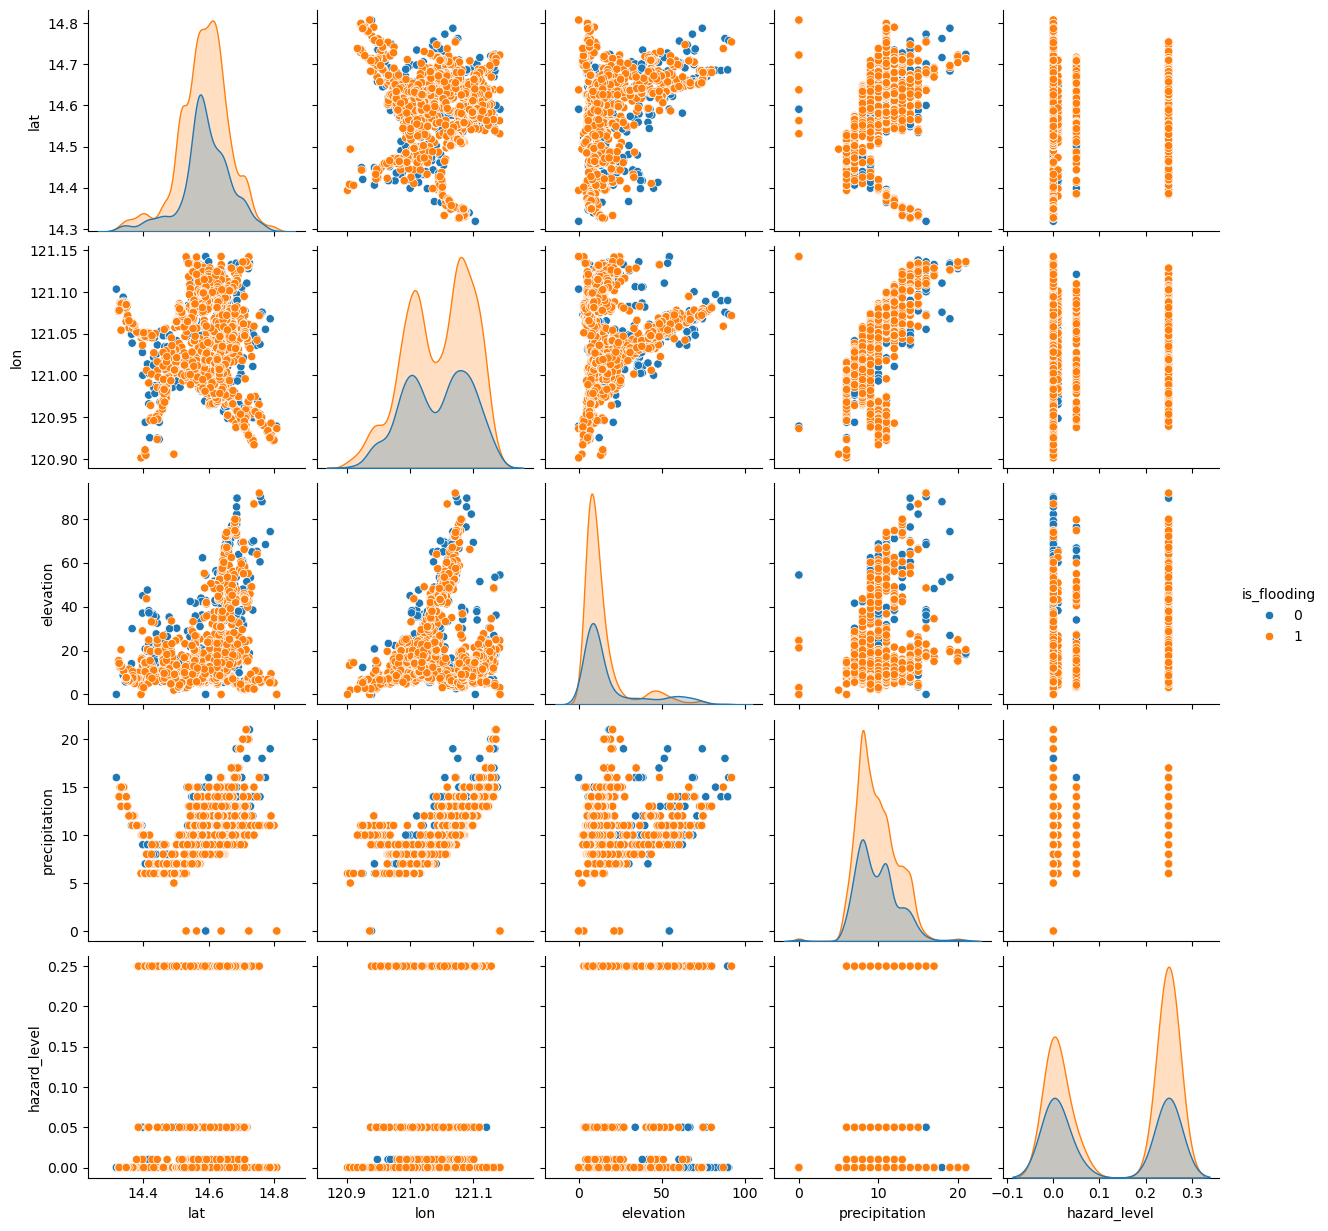

In [19]:
sns.pairplot(df, hue='is_flooding')

In [73]:
reducer = umap.UMAP(random_state=42)
reducer.fit(df)

/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(n_jobs=1, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [77]:
embeddings = reducer.transform(df)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embeddings == reducer.embedding_))
embeddings.shape

(3511, 2)

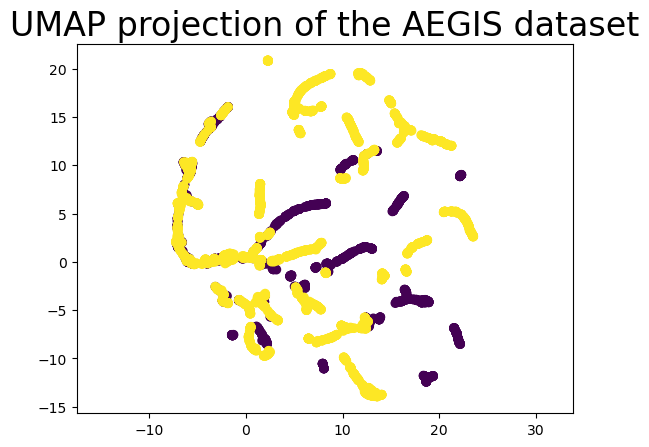

In [26]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=df.is_flooding)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the AEGIS dataset', fontsize=24);

Non-Euclidian Space


In [8]:
df['lat'] = np.radians(df['lat'])
df['lon'] = np.radians(df['lon'])

In [28]:
umap_for_df = df.drop(columns=['lat', 'lon'])

In [29]:
sphere_mapper = umap.UMAP(output_metric='haversine', random_state=42).fit(umap_for_df)

/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [31]:
embeddings = sphere_mapper.transform(umap_for_df)
embeddings.shape

(3511, 2)

In [78]:
data = pd.DataFrame(embeddings, columns=['umap1', 'umap2'])
data['is_flooding'] = df['is_flooding']

In [33]:
x = np.sin(sphere_mapper.embedding_[:, 0]) * np.cos(sphere_mapper.embedding_[:, 1])
y = np.sin(sphere_mapper.embedding_[:, 0]) * np.sin(sphere_mapper.embedding_[:, 1])
z = np.cos(sphere_mapper.embedding_[:, 0])

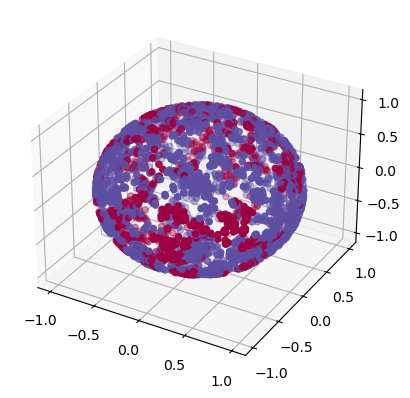

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=df['is_flooding'], cmap='Spectral')

In [35]:
x = np.arctan2(x, y)
y = -np.arccos(z)

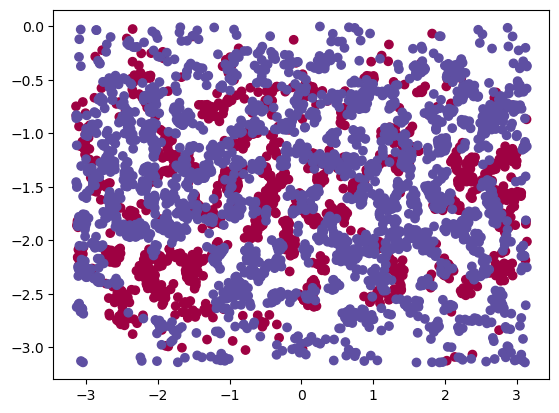

In [36]:
plt.scatter(x, y, c=df['is_flooding'], cmap='Spectral')

### Simulate Spatial Random Forest Regression Model (sklearn)

In [79]:
# Specify columns: Adjust these based on your dataset's actual column names
df = data
target_column = 'is_flooding'      # Binary target column (flood or no flood)
predictor_columns = [col for col in df.columns if col not in target_column]

# Prepare feature matrix (X) and target vector (y)
X = df[predictor_columns].values
y = df[target_column].values

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Normalize the data (optional for non-tree models)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 3: Initialize and Train Models

# Random Forest Classifier for binary flood prediction
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Decision Tree Regressor (optional, if you have continuous flood intensity data)
# dt_model = DecisionTreeRegressor(random_state=42)
# dt_model.fit(X_train, y_train)

# Logistic Regression as an additional baseline model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# Step 4: Evaluate Models on Test Data

# Random Forest Predictions and Evaluation
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_confusion = confusion_matrix(y_test, rf_predictions)
print("Random Forest Classifier Accuracy:", rf_accuracy)
print("Random Forest Confusion Matrix:\n", rf_confusion)

Random Forest Classifier Accuracy: 0.9118065433854907
Random Forest Confusion Matrix:
 [[226  43]
 [ 19 415]]


In [22]:
# Specify columns: Adjust these based on your dataset's actual column names
spatial_features = ['lat', 'lon']  # Spatial features
target_column = 'is_flooding'      # Binary target column (flood or no flood)
predictor_columns = [col for col in df.columns if col not in [target_column, 'lat', 'lon']]

# Prepare feature matrix (X) and target vector (y)
X = df[spatial_features + predictor_columns].values
y = df[target_column].values

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Normalize the data (optional for non-tree models)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 3: Initialize and Train Models

# Random Forest Classifier for binary flood prediction
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Decision Tree Regressor (optional, if you have continuous flood intensity data)
# dt_model = DecisionTreeRegressor(random_state=42)
# dt_model.fit(X_train, y_train)

# Logistic Regression as an additional baseline model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# Step 4: Evaluate Models on Test Data

# Random Forest Predictions and Evaluation
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_confusion = confusion_matrix(y_test, rf_predictions)
print("Random Forest Classifier Accuracy:", rf_accuracy)
print("Random Forest Confusion Matrix:\n", rf_confusion)

# Logistic Regression Predictions and Evaluation
lr_predictions = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_confusion = confusion_matrix(y_test, lr_predictions)
print("Logistic Regression Accuracy:", lr_accuracy)
print("Logistic Regression Confusion Matrix:\n", lr_confusion)

# Decision Tree Regression (only if continuous data is available)
# dt_predictions = dt_model.predict(X_test)
# dt_mse = mean_squared_error(y_test, dt_predictions)
# print("Decision Tree Regression MSE:", dt_mse)

Random Forest Classifier Accuracy: 0.7041251778093883
Random Forest Confusion Matrix:
 [[121 148]
 [ 60 374]]
Logistic Regression Accuracy: 0.647226173541963
Logistic Regression Confusion Matrix:
 [[ 29 240]
 [  8 426]]


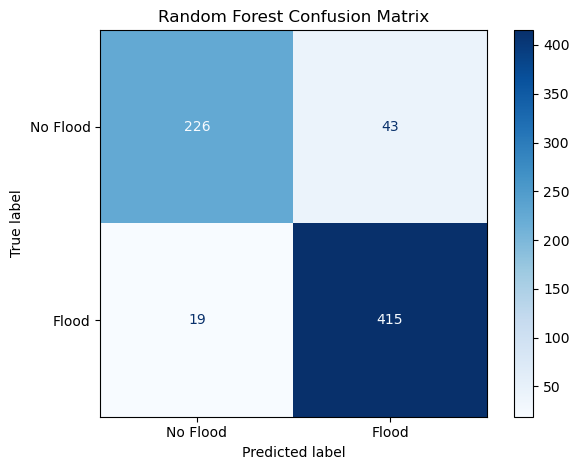

In [80]:
ConfusionMatrixDisplay(rf_confusion, display_labels=['No Flood', 'Flood']).plot(cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()

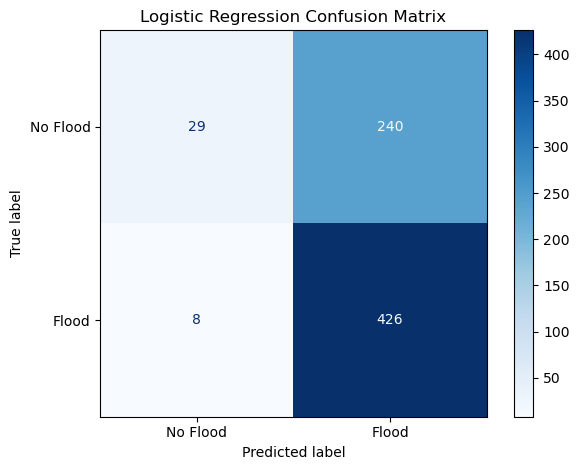

In [24]:
ConfusionMatrixDisplay(lr_confusion, display_labels=['No Flood', 'Flood']).plot(cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.tight_layout()
plt.show()

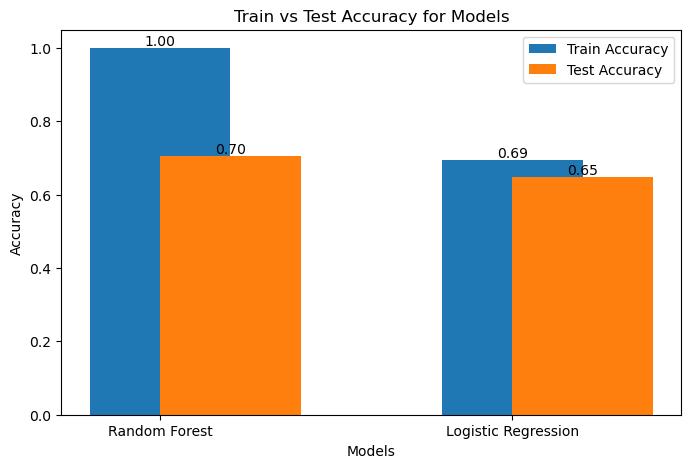

In [25]:
# Compute train accuracy for each model
rf_train_accuracy = accuracy_score(y_train, rf_model.predict(X_train))
lr_train_accuracy = accuracy_score(y_train, lr_model.predict(X_train))

# List of model names and their corresponding train/test accuracies
models = ['Random Forest', 'Logistic Regression']
train_accuracies = [rf_train_accuracy, lr_train_accuracy]
test_accuracies = [rf_accuracy, lr_accuracy]

# Plotting
x = range(len(models))  # Model indices

fig, ax = plt.subplots(figsize=(8, 5))
train_bars = ax.bar(x, train_accuracies, width=0.4, label='Train Accuracy', align='center')
test_bars = ax.bar(x, test_accuracies, width=0.4, label='Test Accuracy', align='edge')

# Labeling each bar with its accuracy value
for bar in train_bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom'
    )

for bar in test_bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom'
    )

# Labeling axes and title
ax.set_xlabel("Models")
ax.set_ylabel("Accuracy")
ax.set_title("Train vs Test Accuracy for Models")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()

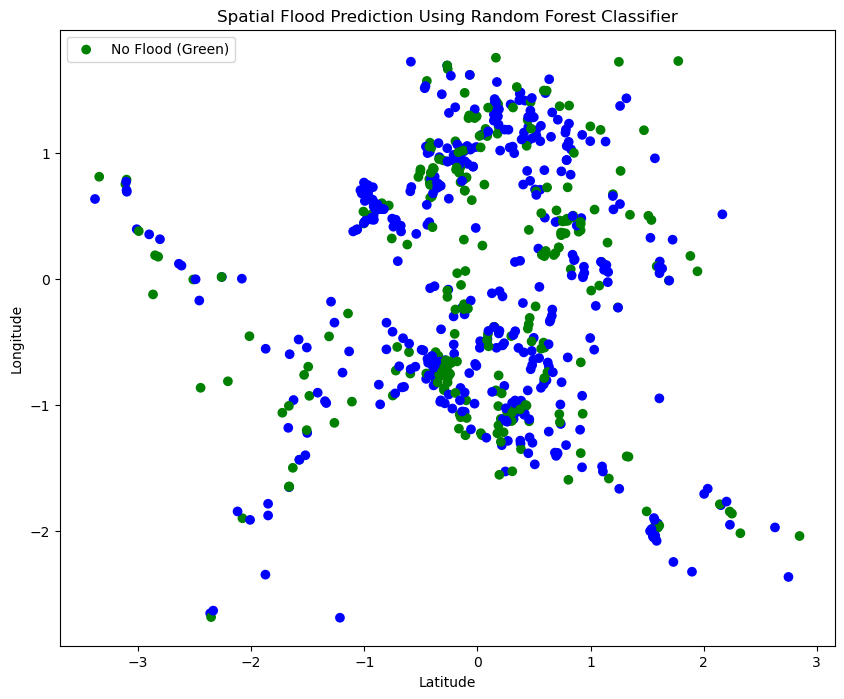

In [7]:
# Step 5: Visualize Spatial Predictions from Random Forest Model
# Assuming latitude and longitude are the first two columns in X_test
plt.figure(figsize=(10, 8))
colors = np.where(rf_predictions == 1, 'blue', 'green')
plt.scatter(X_test[:, 0], X_test[:, 1], c=colors, marker='o', label='Predicted Flood')
# plt.colorbar(label='Flood Prediction')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Spatial Flood Prediction Using Random Forest Classifier')
plt.legend(['No Flood (Green)'])
plt.show()

That wasn't good... Let's try to optimize the hyperparameters.

### Simulate Spatial Random Forest Regression Model (sklearn) with optimization(?)

In [82]:
# Specify columns
target_column = 'is_flooding'
predictor_columns = [col for col in df.columns if col not in target_column]

# Prepare feature matrix (X) and target vector (y)
X = df[predictor_columns].values
y = df[target_column].values

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [85]:
import optuna
# Step 1: Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameters to optimize
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 5, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    # Initialize the model with these hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    
    # Train the model and evaluate it on the validation set
    model = model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, predictions)
    return rmse

# Step 2: Set up Optuna study with TPE sampler
# sampler = optuna.samplers.TPESampler(seed=42)
# study = optuna.create_study(direction="maximize", sampler=sampler)
study = optuna.create_study(direction="minimize")

# Step 3: Run the optimization with a specified number of trials
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best Hyperparameters:", study.best_params)
print("Best RMSE:", study.best_value)

[I 2024-11-12 02:12:45,114] A new study created in memory with name: no-name-130309b1-e064-42ea-b832-930bc74affc1
[I 2024-11-12 02:12:45,463] Trial 0 finished with value: 0.2847473987257497 and parameters: {'n_estimators': 101, 'max_depth': 50, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.2847473987257497.
[I 2024-11-12 02:12:46,419] Trial 1 finished with value: 0.4494346060878711 and parameters: {'n_estimators': 274, 'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 0 with value: 0.2847473987257497.
[I 2024-11-12 02:12:47,582] Trial 2 finished with value: 0.3287979746107146 and parameters: {'n_estimators': 270, 'max_depth': 29, 'min_samples_split': 11, 'min_samples_leaf': 16, 'max_features': None}. Best is trial 0 with value: 0.2847473987257497.
[I 2024-11-12 02:12:47,983] Trial 3 finished with value: 0.292144666905179 and parameters: {'n_estimators': 121, 'max_depth': 13, 'min

Best Hyperparameters: {'n_estimators': 118, 'max_depth': 42, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2'}
Best RMSE: 0.2797072234814643


In [86]:
# refit model
# Use the best hyperparameters to train the final model
best_params = study.best_params
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train, y_train)

# Evaluate on the test set
predictions = best_model.predict(X_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
print(f'Optimized RMSE: {rmse:.2f} minutes')

Optimized RMSE: 0.28 minutes


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [87]:
rf_accuracy = accuracy_score(y_test, predictions)
rf_confusion = confusion_matrix(y_test, predictions)
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Confusion Matrix:\n", rf_confusion)

Random Forest Accuracy: 0.918918918918919
Random Forest Confusion Matrix:
 [[227  42]
 [ 15 419]]


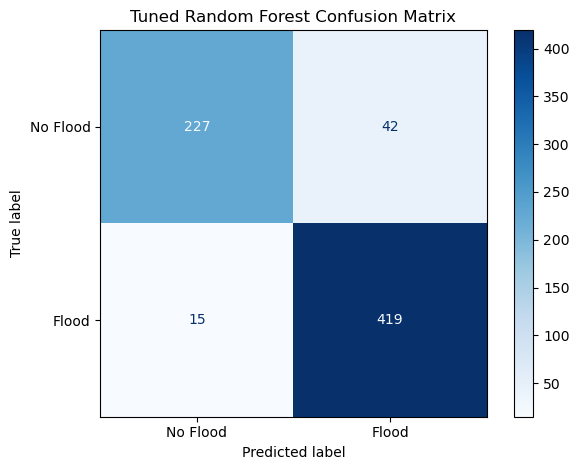

In [88]:
ConfusionMatrixDisplay(rf_confusion, display_labels=['No Flood', 'Flood']).plot(cmap='Blues')
plt.title("Tuned Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()

In [90]:
# Feature Importance
feature_importances = best_model.feature_importances_
feature_names = predictor_columns
sorted_indices = np.argsort(feature_importances)[::-1]

print("Feature Importance Ranking:")
for idx in sorted_indices:
    print(f"{feature_names[idx]}: {feature_importances[idx]:.4f}")

Feature Importance Ranking:
umap2: 0.5585
umap1: 0.4415


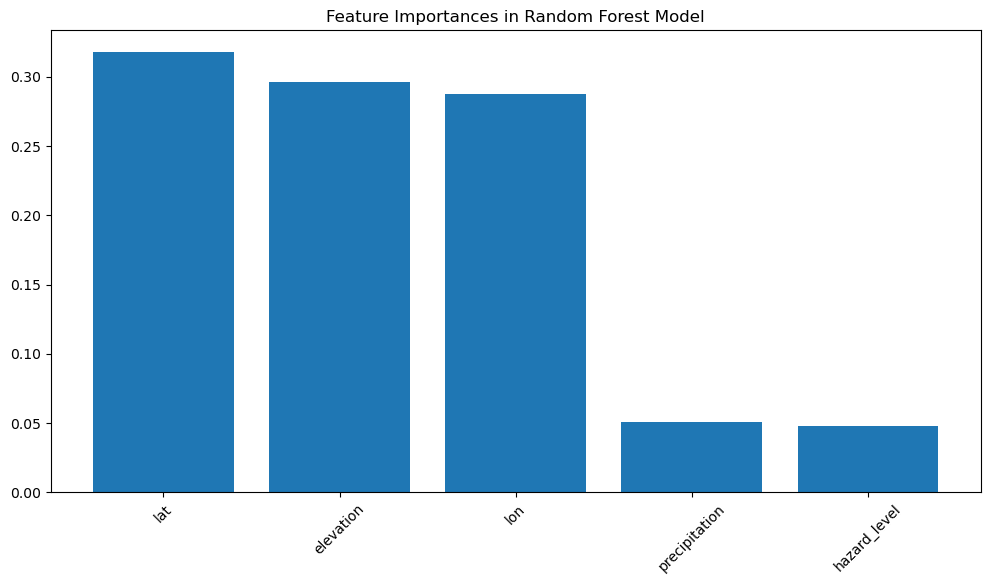

In [37]:
# Visualization of Feature Importance
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(feature_importances)), [feature_names[i] for i in sorted_indices], rotation=45)
plt.title("Feature Importances in Random Forest Model")
plt.show()

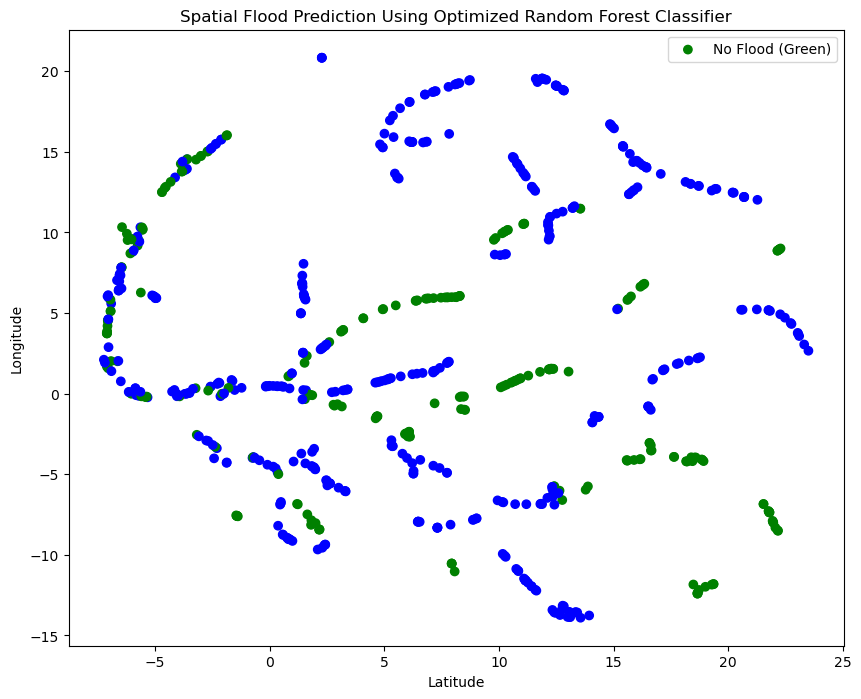

In [92]:
# Visualization of Predictions in UMAP Space
colors = np.where(rf_predictions == 1, 'blue', 'green')
plt.figure(figsize=(10, 8))
plt.scatter(X_test[:, 0], X_test[:, 1], c=colors, marker='o', label='Predicted Flood')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Spatial Flood Prediction Using Optimized Random Forest Classifier')
plt.legend(['No Flood (Green)'])
plt.show()

## Sprf module

### Load Data

In [39]:
# Define target variable and coordinates for the AEGIS dataset
target = 'is_flooding'  # Update if using a different target column
lon = 'lon'             # Replace with the actual longitude column name in your dataset
lat = 'lat'             # Replace with the actual latitude column name in your dataset

### Split into Train and Test

In [37]:
data['lon'] = df['lat']
data['lat'] = df['lon']

In [60]:
data = df

In [48]:
data.head()

,umap1,umap2,is_flooding,lon,lat
0,23.818695,-84.597412,0,14.640394,121.055708
1,18.374092,37.800732,0,14.698299,121.002132
2,-57.763351,35.701462,0,14.698858,121.100261
3,-20.460720,36.693226,0,14.571310,120.983334
4,-25.840223,-19.953157,0,14.762232,121.075735


In [61]:
# Splitting into train and test sets
def prepare_data(data, target, lon=lon, lat=lat):
    """Assumes all columns except lon, lat, and target are covariates."""
    covariates = [col for col in data.columns if col not in [lon, lat, target]]
    return data[covariates], data[target], data[[lon, lat]]

In [62]:
# Random split
inds = np.random.permutation(len(data))
split = int(0.9 * len(data))
train_data = data.iloc[inds[:split]]
test_data = data.iloc[inds[split:]]

# Prepare train and test sets
train_x, train_y, train_coords = prepare_data(train_data, target)
test_x, test_y, test_coords = prepare_data(test_data, target)

In [63]:
# Lists to track accuracy
train_accuracies = []
test_accuracies = []

In [64]:
# Ensure data is binary
print("Unique values in train_y:", np.unique(train_y))
print("Unique values in test_y:", np.unique(test_y))

Unique values in train_y: [0 1]
Unique values in test_y: [0 1]


### Train and test spatial random forest

In [65]:
n_estimators = 100
max_depth = 10
spatial_neighbors = len(data) // 5  # Adjust as needed

In [66]:
# Train and test Spatial Random Forest
sp = SpatialRandomForest(max_depth=max_depth, neighbors=spatial_neighbors)
sp.fit(train_x, train_y, train_coords)
test_pred = sp.predict(test_x, test_coords)

rmse_spatial_rf = root_mean_squared_error(test_pred, test_y)
print("RMSE Error of spatial Random Forest: ", rmse_spatial_rf)

RMSE Error of spatial Random Forest:  0.45889898253319167


In [67]:
thresholds = np.arange(0, 1, 0.01)
scores = []  # TODO: Should we use f1-scores?

for threshold in thresholds:
    binary_predictions = (test_pred >= threshold).astype(int)
    score = roc_auc_score(test_y, binary_predictions)
    scores.append(score)

# Find the threshold that gives the highest F1 score
optimal_threshold = thresholds[np.argmax(scores)]
print("Optimal Threshold for roc-auc-score:", optimal_threshold)

Optimal Threshold for roc-auc-score: 0.67


In [68]:
# Random Forest Predictions and Evaluation
predictions = (test_pred >= optimal_threshold).astype(int)
rf_accuracy = accuracy_score(test_y, predictions)
rf_confusion = confusion_matrix(test_y, predictions)
print("Spatial Random Forest F1 Score:", f1_score(test_y, predictions))
print("Spatial Random Forest Classifier Accuracy:", rf_accuracy)
print("Spatial Random Forest Confusion Matrix:\n", rf_confusion)

Spatial Random Forest F1 Score: 0.6762589928057554
Spatial Random Forest Classifier Accuracy: 0.6164772727272727
Spatial Random Forest Confusion Matrix:
 [[ 76  43]
 [ 92 141]]


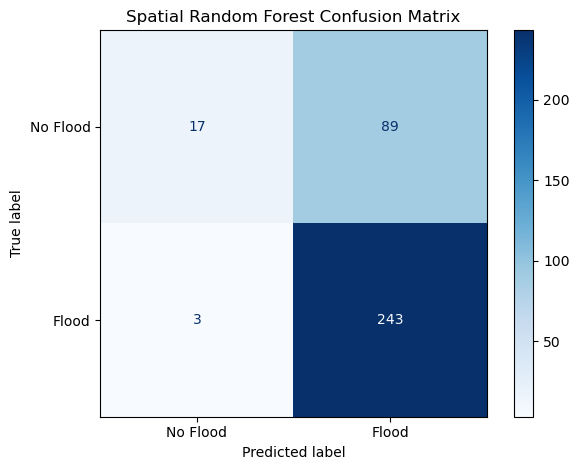

In [17]:
ConfusionMatrixDisplay(rf_confusion, display_labels=['No Flood', 'Flood']).plot(cmap='Blues')
plt.title("Spatial Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()

### Train and test geographical random forest

In [18]:
# Train and test Geographical Random Forest
geo_rf = GeographicalRandomForest(n_estimators=n_estimators, neighbors=spatial_neighbors, max_depth=max_depth)
geo_rf.fit(train_x, train_y, train_coords)
test_pred = geo_rf.predict(test_x, test_coords)

rmse_spatial_rf = root_mean_squared_error(test_pred, test_y)
print("RMSE Error of spatial Random Forest: ", rmse_spatial_rf)

In [19]:
thresholds = np.arange(0, 1, 0.01)
f1_scores = []

for threshold in thresholds:
    binary_predictions = (test_pred >= threshold).astype(int)
    f1 = f1_score(test_y, binary_predictions)
    f1_scores.append(f1)

# Find the threshold that gives the highest F1 score
optimal_threshold = thresholds[np.argmax(f1_scores)]
print("Optimal Threshold for F1-score:", optimal_threshold)

Optimal Threshold for F1-score: 0.19


In [25]:
# Random Forest Predictions and Evaluation
predictions = (test_pred >= optimal_threshold).astype(int)
rf_accuracy = accuracy_score(test_y, predictions)
rf_confusion = confusion_matrix(test_y, predictions)
print("Geographical RF F1 Score:", f1_score(test_y, predictions))
print("Geographical RF Classifier Accuracy:", rf_accuracy)
print("Geographical RF Confusion Matrix:\n", rf_confusion)

RMSE Error of Geographical Random Forest:  0.5222329678670935
Geographical RF F1 Score: 0.8356164383561644
Geographical RF Classifier Accuracy: 0.7272727272727273
Geographical RF Confusion Matrix:
 [[ 12  94]
 [  2 244]]


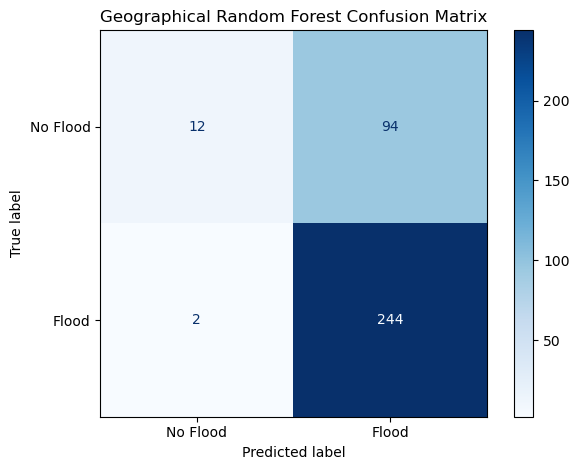

In [28]:
ConfusionMatrixDisplay(rf_confusion, display_labels=['No Flood', 'Flood']).plot(cmap='Blues')
plt.title("Geographical Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()

### Tune number of neighbors

In [27]:
tuned_sp_rf = SpatialRandomForest(n_estimators=n_estimators, neighbors=500, max_depth=max_depth)
tuned_sp_rf.tune_neighbors(train_x, train_y, train_coords)
print("Tuned spatial rf neighbors:", tuned_sp_rf.neighbors)

# Train tuned Spatial Random Forest
tuned_sp_rf.fit(train_x, train_y, train_coords)
test_pred = tuned_sp_rf.predict(test_x, test_coords)

rmse_spatial_rf_tuned = root_mean_squared_error(test_pred, test_y)
print("RMSE Error of tuned spatial Random Forest: ", rmse_spatial_rf_tuned)

Tuned spatial rf neighbors: 2871
RMSE Error of tuned spatial Random Forest:  0.44874451503827345


# Conclusion